<a href="https://colab.research.google.com/github/syedsajidhussain/ideal-computing-machine/blob/main/sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

file count: 116
skipped, no SliceLocation: 0
(500, 500, 580) float64 0.0 1.0


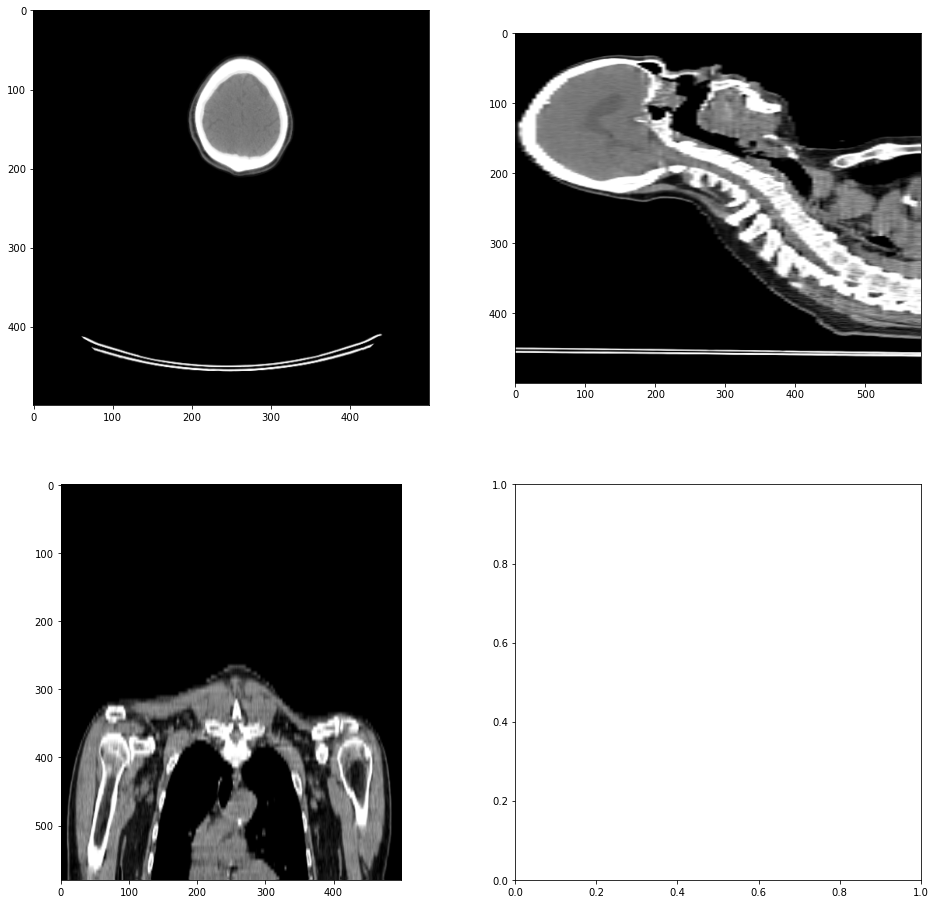

In [ ]:
import os
import pydicom
import skimage
import numpy as np
import matplotlib.pyplot as plt

import skimage.measure
import skimage.transform
import skimage.morphology

# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from utils_dicom import decode_dicom, convert_to_obj

# load the DICOM files
folder = "./data/2.000000-Neck  5.0  B31s-27819"
# folder = "./data/2.000000-Neck  5.0  B31s-99579"
# folder = "./data/3.000000-HeadNeck  3.0  B31s-71607"
# folder = "./data/3.000000-WholeBody  5.0  B31f-54664"
# folder = "./data/3.000000-CT WB  4.0  B31s-06637"

files = []
for fname in os.listdir(folder):
    if fname.endswith('.dcm') or fname.endswith('.dicom') and not fname.startswith('.'):
        files.append(pydicom.dcmread(os.path.join(folder, fname)))

print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness

# create 3D array
img_shape = (slices[0].Rows, slices[0].Columns, len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files, also remove the bed 
for i, s in enumerate(slices):
    img2d = decode_dicom(s, view_idx=0)
    img3d[:, :, i] = img2d


real_shape = (int(img_shape[0] * ps[0]), int(img_shape[1] * ps[1]), int(img_shape[2] * ss))
img3d = skimage.transform.resize(img3d, real_shape, preserve_range=True, anti_aliasing=True)
print(img3d.shape, img3d.dtype, img3d.min(), img3d.max())

hist_centers, hist = skimage.exposure.histogram(img3d)
# plot 3 orthogonal slices
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
ax = axes.ravel()
ax[0].imshow(img3d[:, :, img_shape[2]//2], cmap="gray")
ax[1].imshow(img3d[:, img_shape[1]//2, :], cmap="gray")
ax[2].imshow(img3d[img_shape[0]//2, :, :].T, cmap="gray")
# ax[3].plot(hist_centers[1:-1], hist[1:-1], lw=2)
# ax[3].set_title('Gray-level histogram exclude bone and bg')
plt.show()

# hist_centers, hist = skimage.exposure.histogram(img2d)
# plt.plot(hist_centers[1:-1], hist[1:-1], lw=2)

# fig, axes = plt.subplots(29, 4, figsize=(4*6, 29*6))
# ax = axes.ravel()
# for i in range(img3d.shape[-1]):
#     ax[i].imshow(img3d[..., i], cmap="gray")
# plt.show()

# display annotation
## 18, -412, 1205
# img3d[:, :, 1205//5]
print(img3d.shape)
img2d = decode_dicom(slices[43], view_idx=0)
plt.imshow(img2d)
plt.plot(512-204, 56, 'ro')
plt.plot(512-270, 51, 'ro') 
plt.show()

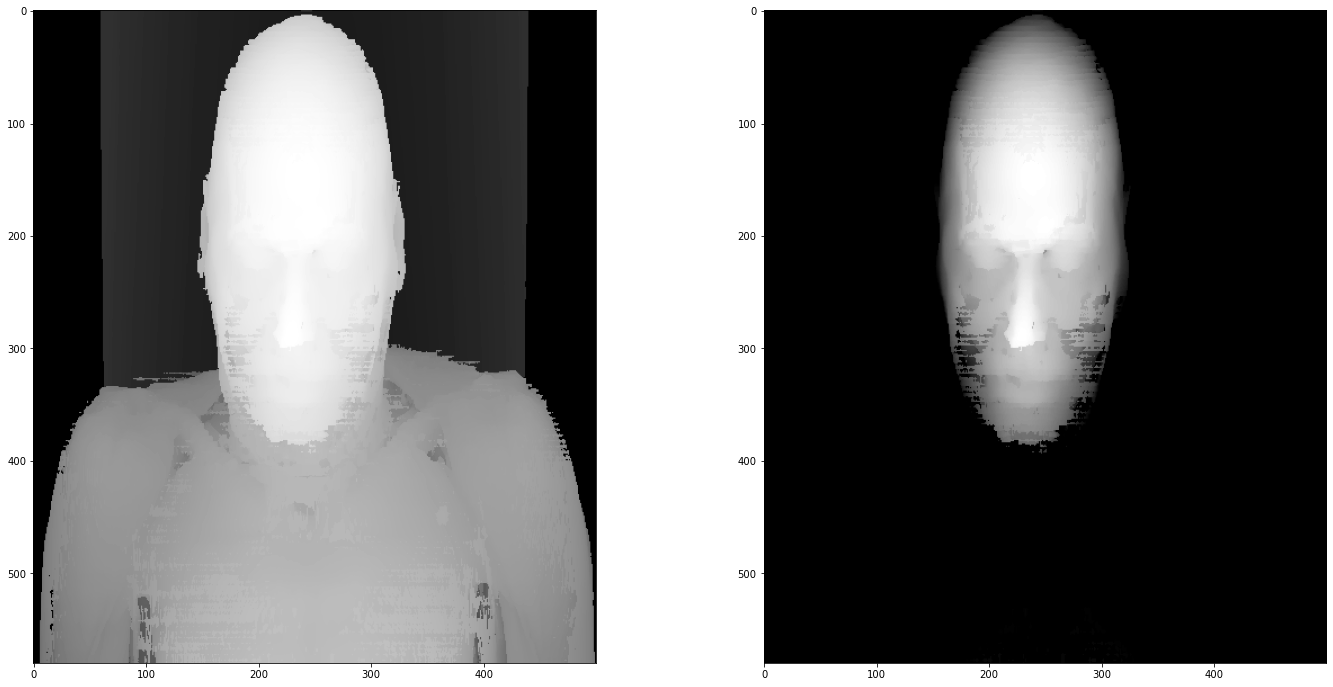

In [ ]:
import skimage.exposure

proj = np.zeros((580, 500))
vals = np.zeros((580, 500))
for x, y, z in zip(*np.where(img3d > 0.3)):
    d = 1. - x/500.
    if d > proj[z, -y]:
        proj[z, -y] = d
        vals[z, -y] = img3d[x, y, z]

# rescale by value
proj2 = skimage.exposure.rescale_intensity(proj, in_range=(0.7, np.max(proj)), out_range='image')

fig, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].imshow(proj, cmap='gray')
axes[1].imshow(proj2, cmap='gray')
plt.show()

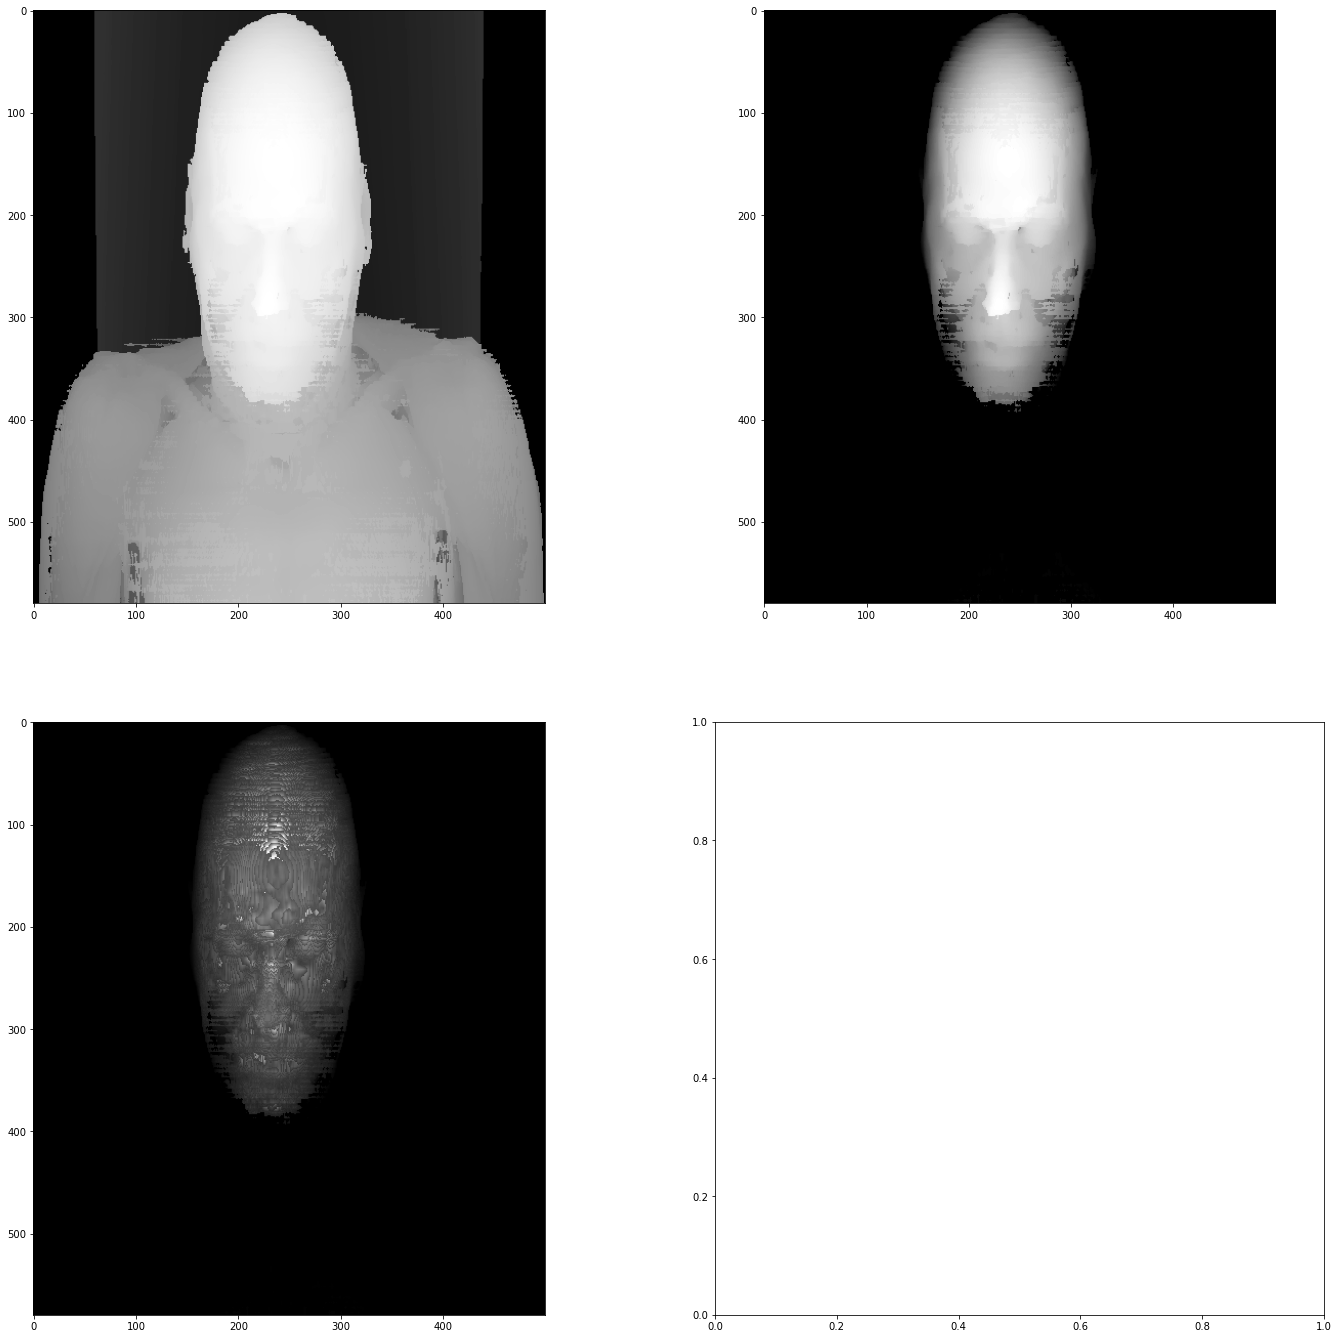

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(24, 24))
axes = axes.ravel()
axes[0].imshow(proj, cmap='gray')
axes[1].imshow(proj2, cmap='gray')
axes[2].imshow(vals*proj2, cmap='gray')
# axes[3].imshow
plt.show()



In [ ]:
## train a mobilenet detection model
import torchvision
model = torchvision.models.mobilenet_v2(pretrained=True)
model = torchvision.models.mobilenet_v3_small(pretrained=True)



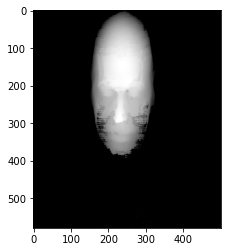

In [ ]:
import skimage.exposure
# proj2 = proj.copy()
# proj2[proj2 < 0.7] = 0
proj2 = skimage.exposure.rescale_intensity(proj, in_range=(0.7, np.max(proj2)), out_range='image')
fig = plt.imshow()
plt.imshow(proj2, cmap='gray')
plt.show()

(500, 500, 580)


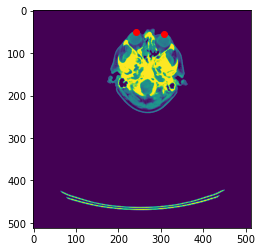

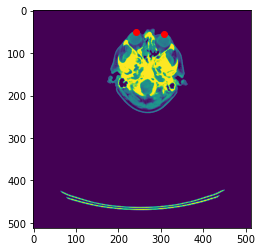

In [ ]:
img2d = decode_dicom(slices[43], view_idx=0)
plt.imshow(img2d)
plt.plot(512-204, 56, 'ro')
plt.plot(512-270, 51, 'ro') 
plt.show()

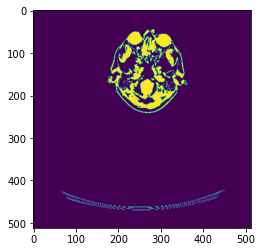

In [ ]:
plt.imshow((img2d > 0.3)*1.0 - (img2d >= 0.9)*1.0)
# plt.plot(hist_centers, hist, lw=2)

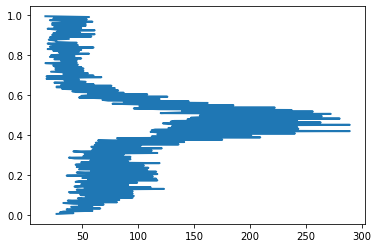

In [ ]:
# extract bone
bone3d = img3d >= 0.9
bone3d = skimage.morphology.remove_small_holes(bone3d, area_threshold=64)
bone3d = skimage.morphology.remove_small_objects(bone3d, min_size=64)

# plot 3 orthogonal slices
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
ax = axes.ravel()
ax[0].imshow(bone3d[:, :, img_shape[2]//2], cmap="gray")
ax[1].imshow(bone3d[:, img_shape[1]//2, :], cmap="gray")
ax[2].imshow(bone3d[img_shape[0]//2, :, :].T, cmap="gray")
plt.show()

# n_plots = bone3d.shape[-1]//5
# n_row = (n_plots+3)//4
# fig, axes = plt.subplots(n_row, 4, figsize=(6*4, 6*n_row))
# ax = axes.ravel()
# for i in range(n_plots):
#     ax[i].imshow(bone3d[..., i*5], cmap="gray")
# plt.show()

bone_obj = convert_to_obj(bone3d, "test_bone.obj")

In [ ]:
# extract ventricle
no_bone = (img3d < 0.9) * img3d

def bed_region(prop):
    x0, y0, x1, y1 = prop.bbox
    return x0 > 300 and y1-y0 > 350 and (y1-y0)/(x1-x0) > 7
    
n_slides = no_bone.shape[-1]
n_slides = 200
vent3d = np.zeros(img3d.shape)
for i in range(n_slides):
    s = no_bone[..., i]
    
    disk_size = int(i/30)*4+1
    tmp = skimage.morphology.binary_opening(s > 0, np.ones((disk_size, disk_size)))
    label_image = skimage.measure.label(s > 0)
    props = skimage.measure.regionprops(label_image, intensity_image=s)
    props = [_ for _ in props if not bed_region(_)]
    props = sorted(props, key=lambda x: x.bbox_area, reverse=True)
    
    if len(props) >= 2 and props[1].bbox[0] <= 300:
        x0, y0, x1, y1 = props[1].bbox
        vent3d[x0:x1, y0:y1, i] = props[1].intensity_image
    else:
        print("==================")
        print("Failed segmentation: slice_{}".format(i))
#         fig, axes = plt.subplots(1, 2, figsize=(16, 8))
#         axes = axes.ravel()
#         for ax, _ in zip(axes, props):
#             ax.imshow(_.intensity_image)
#         plt.show()

In [ ]:
# plot 3 orthogonal slices
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
ax = axes.ravel()
ax[0].imshow(vent3d[:, :, img_shape[2]//2], cmap="gray")
ax[1].imshow(vent3d[:, img_shape[1]//2, :], cmap="gray")
ax[2].imshow(vent3d[img_shape[0]//2, :, :].T, cmap="gray")
plt.show()

# n_plots = vent3d.shape[-1]//5
# n_row = (n_plots+3)//4
# fig, axes = plt.subplots(n_row, 4, figsize=(6*4, 6*n_row))
# ax = axes.ravel()
# for i in range(n_plots):
#     ax[i].imshow(vent3d[..., i*5], cmap="gray")
# plt.show()

vent_obj = convert_to_obj(vent3d, "test_vent.obj")

In [ ]:


# 
# vent3d = (img3d < 0.9) * img3d
# vent3d = (img3d.clip(0, 0.9) > 0)#  ^ (img3d >= 0.9)
# # vent3d = skimage.morphology.remove_small_holes(bone3d, area_threshold=64)
# # vent3d = skimage.morphology.remove_small_objects(bone3d, min_size=64)

# # plot 3 orthogonal slices
# fig, axes = plt.subplots(1, 3, figsize=(24, 8))
# ax = axes.ravel()
# ax[0].imshow(vent3d[:, :, img_shape[2]//2], cmap="gray")
# ax[1].imshow(vent3d[:, img_shape[1]//2, :], cmap="gray")
# ax[2].imshow(vent3d[img_shape[0]//2, :, :].T, cmap="gray")
# plt.show()

